In [1]:
%matplotlib inline
from StringProcessing import StringProcessing
from BuildVocabulary import BuildVocabulary as bv
from TransformerEncoder import TransformerEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from nltk.tokenize.toktok import ToktokTokenizer
from Visualization import Visualization
from gensim.models import Word2Vec
from Preprocess import Preprocess
from Utils import Utils
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Parameters

In [2]:
# Text parameters #
max_words = 50
test_path = "./tass-corpus/es/dev.csv" # Dev

# Training Parameters #
path_model = "./best-models/transformer_es.hdf5"
r_cats = {0:"N", 1:"NEU", 2:"NONE", 3:"P"}
tokenizer = ToktokTokenizer()
w2v_path = "./twitter87/twitter87.model"
w2v = Word2Vec.load(w2v_path)

# Encoder Parameters # # MEJOR
dropout_input = 0.7 #0.7
dropout_output = 0. # 0.
pe = False #False
embedding_dims = w2v.vector_size
n_encoders = 1 #2 #1
attention_dims = 64 #32 #64
n_heads = 8 #8
dim_h = 128 #256
final_h = False #False
pool_mode = "average" #"average"

output_encoder_dims = [embedding_dims for i in range(n_encoders)]
attention_dims = [attention_dims for i in range(n_encoders)]
n_heads = [n_heads for i in range(n_encoders)]

# Prepare inputs #

In [3]:
ids_dv, x_dv, y_dv = StringProcessing.load_samples(test_path)

# Preprocess #
x_dv = [Preprocess.preprocess(x, tokenizer) for x in x_dv]

# Represent #
rx_dv = np.array(StringProcessing.represent_documents(x_dv, max_words, embedding_dims, w2v, word_delimiter = " "))

# Masks #
masks_dv = np.array([((rx!=0).sum(axis=1)>0).astype("int") for rx in rx_dv])

# Positional Encodings #
matrix_pos_encodings = Utils.precompute_sent_pos_encodings(max_words, embedding_dims)
pe_dv = np.array([Utils.build_pe_sent_encodings(matrix_pos_encodings, m) for m in masks_dv])

# Load model

In [4]:
ht = TransformerEncoder(max_words = max_words,
                 embedding_dims = embedding_dims,
                 output_encoder_dims = output_encoder_dims,
                 attention_dims = attention_dims,
                 n_heads = n_heads,
                 dropout_input = dropout_input,
                 dropout_output = dropout_output,
                 pe = pe,
                 dim_h = dim_h,
                 final_h = final_h,
                 pool_mode = pool_mode)

ht.build()
print(ht.model.summary())
ht.compile(ht.model)
ht.load(ht.model, path_model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
my_masking_1 (MyMasking)        (None, 50, 300)      0           input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 300)      0           my_masking_1[0][0]               
__________________________________________________________________________________________________
sentence_encoder_bloc

# Predict

In [5]:
preds = ht.model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)
preds = [r_cats[p.argmax()] for p in preds]
truths = y_dv
print("Acc: %f" % accuracy_score(truths, preds))
print("MF1: %f" % f1_score(truths, preds, average="macro"))
print("MP: %f" % precision_score(truths, preds, average="macro"))
print("MR: %f" % recall_score(truths, preds, average="macro"))
print("Conf Matrix\n", confusion_matrix(truths, preds))
print("Classification Report\n", classification_report(truths, preds))

Acc: 0.607573
MF1: 0.533422
MP: 0.527952
MR: 0.543807
Conf Matrix
 [[195  25  18  28]
 [ 25  22  13  23]
 [  9   6  38  11]
 [ 38  19  13  98]]
Classification Report
               precision    recall  f1-score   support

           N       0.73      0.73      0.73       266
         NEU       0.31      0.27      0.28        83
        NONE       0.46      0.59      0.52        64
           P       0.61      0.58      0.60       168

   micro avg       0.61      0.61      0.61       581
   macro avg       0.53      0.54      0.53       581
weighted avg       0.61      0.61      0.61       581



# Save Prediction Report

In [6]:
# Guarda un csv (texto, real, prediccion)
fw = open("results_report.csv", "w", encoding="utf8")
for i in range(len(preds)):
    fw.write(x_dv[i] + "\t" + truths[i] + "\t" + preds[i] + "\n")
fw.close()

# Get Attention Report

In [7]:
attns = ht.attn_model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)

## All classes (creo que este es el análisis bueno, más que por cada clase)

In [12]:
# Palabra : {cabezal : }

word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = truths[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = 0.
                counters[word][h] = 0.

            word_attns[word][h] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        word_attns[w][h] /= (counters[w][h] + 1e-16) #len(x_dv) 

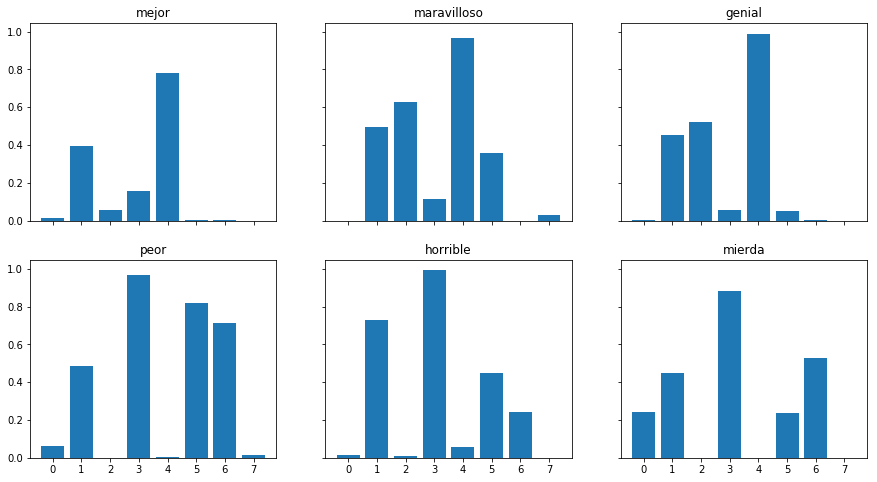

In [40]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)

#fig.suptitle('Attention')

ax[1, 0].set_xticks([i for i in range(8)])

w1 = "mejor"
w2 = "maravilloso"
w3 = "genial"
w4 = "peor"
w5 = "horrible"
w6 = "mierda"

ax[0, 0].set_title(w1)
ax[0, 1].set_title(w2)
ax[0, 2].set_title(w3)
ax[1, 0].set_title(w4)
ax[1, 1].set_title(w5)
ax[1, 2].set_title(w6)

x1 = x1 = x2 = x3 = x4 = x5 = x6 = list(range(8))

y1 = list(word_attns[w1].values())
y2 = list(word_attns[w2].values())
y3 = list(word_attns[w3].values())
y4 = list(word_attns[w4].values())
y5 = list(word_attns[w5].values())
y6 = list(word_attns[w6].values())

fig.subplots_adjust(wspace=0.2, hspace=0.2)

ax[0, 0].bar(x1, y1)
ax[0, 1].bar(x2, y2)
ax[0, 2].bar(x3, y3)
ax[1, 0].bar(x4, y4)
ax[1, 1].bar(x5, y5)
ax[1, 2].bar(x6, y6)

fig.savefig("attentions.pdf", bbox_inches='tight')

Parece que el cabezal 3 reacciona mucho con palabras negativas y poco a las positivas; y el cabezal 4 justo al contrario

# Attns Visualization

In [104]:
n = 40 # 46 (PE), 40 (ES)
attns_i = attns[n]
l_words = x_dv[n].split()

pad = 0
while len(l_words) < max_words:
    l_words.insert(0, "<pad>")
    pad += 1
l_words = l_words[pad:]
attns_i = attns_i[:, pad:, pad:]
attns_h_3 = attns_i[3]
attns_h_4 = attns_i[4]

In [105]:
print(x_dv[n])

odio a lucia la vd , mi amor hacia ella es una gran tapadera pa comer nutella en su casa


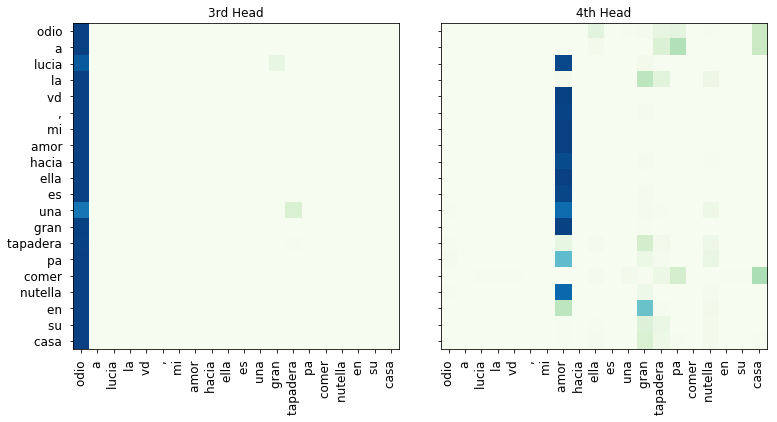

In [107]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(16)
ticks = l_words
tick_labels = [x+ " " for x in ticks]

ax[0].set_xticks(np.arange(len(tick_labels)))
ax[0].set_yticks(np.arange(len(tick_labels)))
ax[1].set_xticks(np.arange(len(tick_labels)))
ax[0].set_xticklabels(tick_labels, rotation='vertical', fontsize=12, visible = True)
ax[0].set_yticklabels(tick_labels, fontsize=12, visible = True)
ax[1].set_xticklabels(tick_labels, rotation='vertical', fontsize=12, visible = True)
ax[1].set_yticklabels(tick_labels, fontsize=12, visible = True)

ax[0].set_title("3rd Head")
ax[1].set_title("4th Head")

fig.subplots_adjust(wspace=-0.3)

ax[0].imshow(attns_h_3, cmap="GnBu")
ax[1].imshow(attns_h_4, cmap="GnBu")

fig.savefig("heads_example.pdf", bbox_inches='tight')

Es una muestra negativa, predicha correctamente por el sistema. La atención a "odio" del cabezal 3 es mayor que las atenciones a "amor" del cabezal 4.

# Análisis con un lexicon

In [109]:
import unicodedata as uc

def remove_accents(sequence):
    return "".join([c for c in uc.normalize('NFD', sequence) if uc.category(c) != 'Mn'])

In [110]:
lex = open("./lexicons/elhuyar.txt", "r", encoding="utf8")
llex = []
for line in lex.readlines():
    s = line.strip().split("\t")
    if len(s)>1:
        word, tag = s[0], s[1]
        if "_" not in word and "-" not in word:
            word = remove_accents(word.replace("ñ", "ny"))
            llex.append((word, tag))
lex.close()

In [111]:
fw = open("attentions_elhuyar.out", "w", encoding="utf8")
for (word, tag) in llex:
    if word in word_attns:
        fw.write(word + "\n")
        for h in word_attns[word]:
            fw.write("Header %d: %.4f\n" % (h, word_attns[word][h]))
        fw.write("\n\n" + "-"*50 + "\n\n")
fw.close()

### Buscar los cabezales que maximizan su valor de atención sobre un lexicon supervisado en español (Elhuyar de ejemplo) #

In [112]:
positive_words = [word for (word, tag) in llex if tag == "positive"]
negative_words = [word for (word, tag) in llex if tag == "negative"]

In [113]:
sum_attns_positive = np.array([0. for i in range(len(word_attns["de"]))])
counts = 0.

for word in positive_words:
    if word in word_attns:
        w_attns = word_attns[word]
        h_attns = np.array([word_attns[word][h] for h in word_attns[word]])
        sum_attns_positive += h_attns
        counts += 1.
        
sum_attns_positive /= counts

In [114]:
sum_attns_negative = np.array([0. for i in range(len(word_attns["de"]))])
counts = 0.

for word in negative_words:
    if word in word_attns:
        w_attns = word_attns[word]
        h_attns = np.array([word_attns[word][h] for h in word_attns[word]])
        sum_attns_negative += h_attns
        counts += 1.
        
sum_attns_negative /= counts

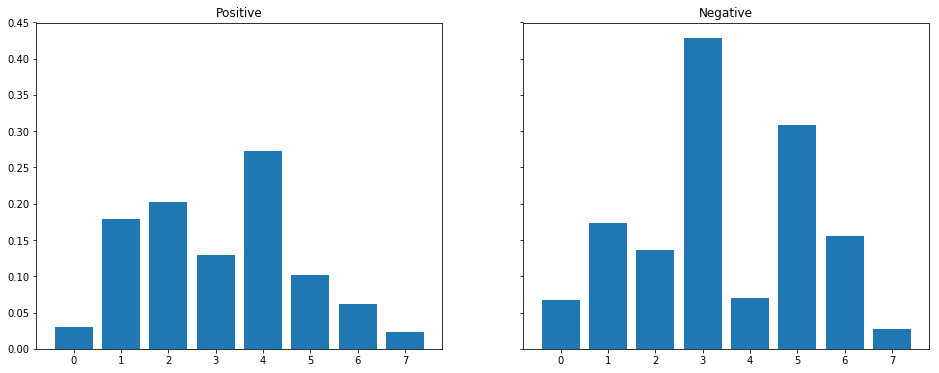

In [116]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(16)

#fig.suptitle('Attention')

ax[0].set_xticks([i for i in range(8)])


ax[0].set_title("Positive")
ax[1].set_title("Negative")

x1 = x2 = list(range(8))

y1 = sum_attns_positive
y2 = sum_attns_negative

fig.subplots_adjust(wspace=0.2)

ax[0].bar(x1, y1)
ax[1].bar(x2, y2)

fig.savefig("attention_sums_elhuyar.pdf", bbox_inches='tight')

Los cabezales 0 y 7 no capturan nada de sentimiento, ¿qué capturan?

### Clasificar el lexicon usando los cabezales 3 y 4 (75% Acc)

In [275]:
n_errors = 0.
n_words = 0.

for (word, tag) in llex:
    if word in word_attns:
        heads = word_attns[word]
        if heads[3] > heads[4]:
            pred = "negative"
        else:
            pred = "positive"
        
        if pred != tag:
            n_errors += 1
            
        n_words += 1.
        
print("Acc: %.4f%%" % ((1. - ((n_errors / n_words))) * 100))

Acc: 74.7573%


# Buscar cabezales que encuentren la negación

<BarContainer object of 8 artists>

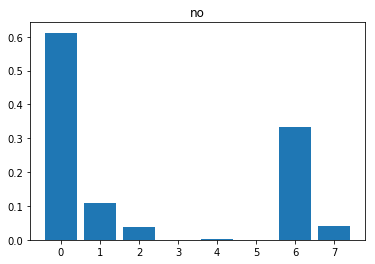

In [276]:
w = "no"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

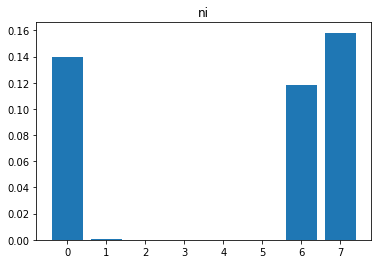

In [277]:
w = "ni"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

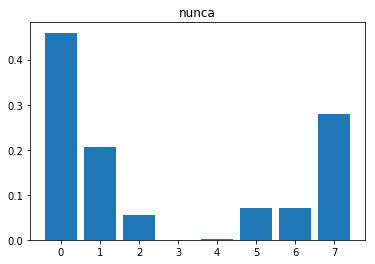

In [278]:
w = "nunca"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

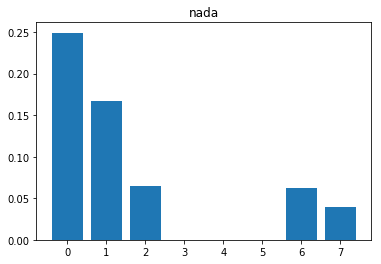

In [279]:
w = "nada"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

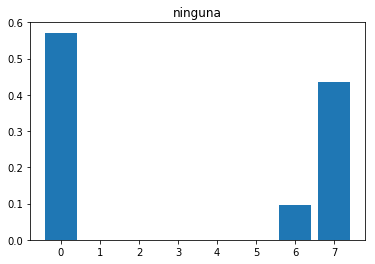

In [280]:
w = "ninguna"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

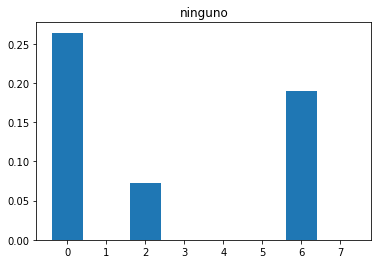

In [281]:
w = "ninguno"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

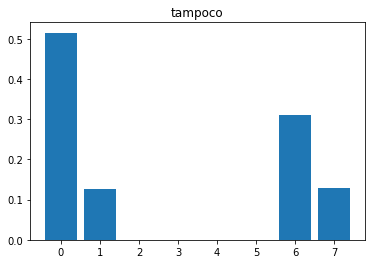

In [282]:
w = "tampoco"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

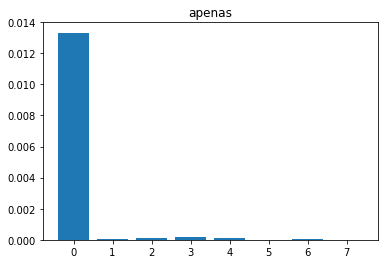

In [283]:
w = "apenas"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

El cabezal 0 reacciona a la negación, además los cabezales 3 y 4 relacionados con la polaridad tienen valor 0.
Aun así, los valores de atención no son muy elevados, i.e. el cabezal 0 sirve para más cosas (conjunciones, etc.)
El cabezal no solo reacciona a la negación, también reacciona a: (siempre, todo, toda, todos, todas, si)

<BarContainer object of 8 artists>

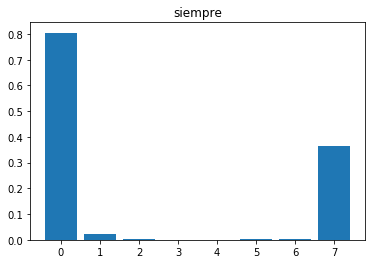

In [284]:
w = "siempre"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

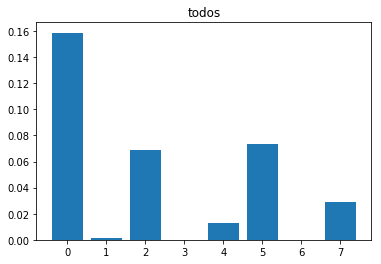

In [285]:
w = "todos"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

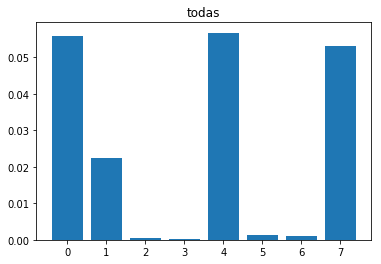

In [286]:
w = "todas"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

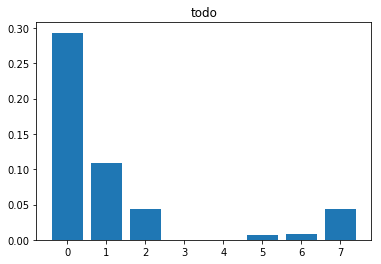

In [287]:
w = "todo"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

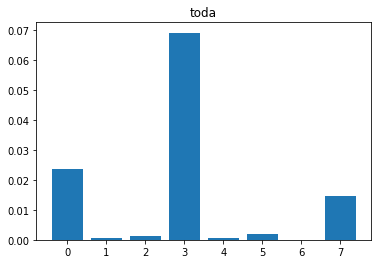

In [288]:
w = "toda"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

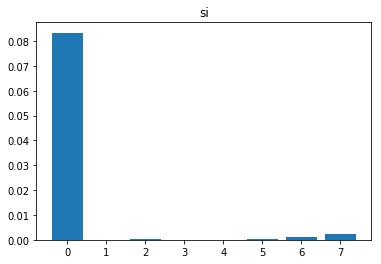

In [289]:
w = "si"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

<BarContainer object of 8 artists>

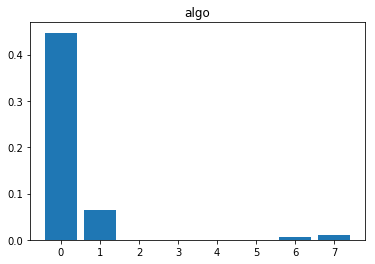

In [290]:
w = "algo"
plt.title(w)
plt.bar(list(range(8)), list(word_attns[w].values()))

Casi toda la atención a los modificadores (polarity reversers y polarity shifters, https://wiltrud.hwro.de/teaching/sentan12s/polarity_modifiers.pdf) se concentra en el cabezal 0.

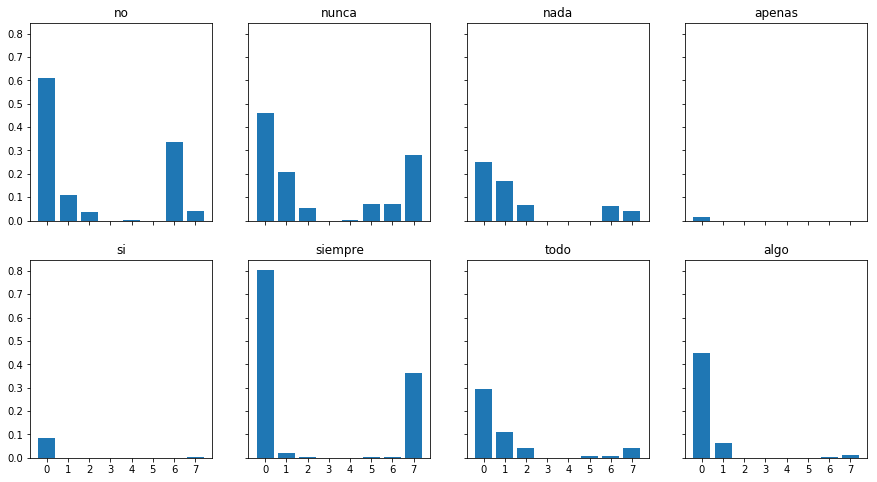

In [119]:
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)

#fig.suptitle('Attention')

ax[1, 0].set_xticks([i for i in range(8)])

w1 = "no"
w2 = "nunca"
w3 = "nada"
w4 = "apenas"
w5 = "si"
w6 = "siempre"
w7 = "todo"
w8 = "algo"

ax[0, 0].set_title(w1)
ax[0, 1].set_title(w2)
ax[0, 2].set_title(w3)
ax[0, 3].set_title(w4)
ax[1, 0].set_title(w5)
ax[1, 1].set_title(w6)
ax[1, 2].set_title(w7)
ax[1, 3].set_title(w8)

x1 = x1 = x2 = x3 = x4 = x5 = x6 = x7 = x8 = list(range(8))

y1 = list(word_attns[w1].values())
y2 = list(word_attns[w2].values())
y3 = list(word_attns[w3].values())
y4 = list(word_attns[w4].values())
y5 = list(word_attns[w5].values())
y6 = list(word_attns[w6].values())
y7 = list(word_attns[w7].values())
y8 = list(word_attns[w8].values())

fig.subplots_adjust(wspace=0.2, hspace=0.2)

ax[0, 0].bar(x1, y1)
ax[0, 1].bar(x2, y2)
ax[0, 2].bar(x3, y3)
ax[0, 3].bar(x4, y4)
ax[1, 0].bar(x5, y5)
ax[1, 1].bar(x6, y6)
ax[1, 2].bar(x7, y7)
ax[1, 3].bar(x8, y8)

fig.savefig("shifters.pdf", bbox_inches='tight')

# Ver las palabras que maximizan la atención de cada cabezal

In [291]:
headers = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

In [292]:
for word in word_attns.keys():
    for h in headers:
        headers[h].append((word, word_attns[word][h]))
        
for h in headers:
    headers[h].sort(key=lambda tup: tup[1], reverse=True)

In [293]:
headers[5]

[('deprimida', 0.9999945958455404),
 ('resignado', 0.9998782475789388),
 ('raro', 0.9998567899068197),
 ('muriendo', 0.9997968077659607),
 ('cansado', 0.9997426277551895),
 ('diria', 0.9956971044125764),
 ('perdoname', 0.9953701496124268),
 ('jodido', 0.9953599993387859),
 ('jodidos', 0.9949414730072021),
 ('melancolia', 0.9916713578360421),
 ('asustado', 0.9886963844299317),
 ('grasioso', 0.9877354303995768),
 ('triste', 0.9877258863903228),
 ('vacia', 0.9853814670017788),
 ('imagino', 0.9851462322732677),
 ('pobre', 0.9846955721194928),
 ('apena', 0.9830211457752046),
 ('soportas', 0.9789827346801758),
 ('echo', 0.977647521279075),
 ('enfadado', 0.9756386280059814),
 ('hipocrita', 0.9749569892883301),
 ('deprime', 0.9737548828125),
 ('expresa', 0.9726239310370551),
 ('insoportable', 0.9713117936078239),
 ('odio', 0.9711576339591788),
 ('preocupado', 0.971133804321289),
 ('inocente', 0.9708276228471235),
 ('temo', 0.9643850326538086),
 ('soporto', 0.9607435862223307),
 ('ardido', 0.95